# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow import keras
import os
import time
import random
import glob # Khoa's stuff
from IPython import display
from tqdm import tqdm # for training progress
import wave

# Utilities
import scipy.io.wavfile as wav
from utils.audio_spectrogram import stft_np as stft
from utils.img_processing import mask_image
from PIL import Image

# Models
from models.deepfake_generator import combined_generator, generator # Generator is only for plotting
from models.visual_quality_discriminator import quality_discriminator

2023-02-11 05:47:55.694545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 05:47:56.204776: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/khoa/.local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11/lib64:
2023-02-11 05:47:56.204831: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/khoa/.local/lib/python3.10/site-pac

# Constants

In [2]:
EPOCHS = 500
BATCH_SIZE = 100
POSE_PRIOR = Image.open("./test_face.png") # constant for now
POSE_PRIOR = np.asarray(POSE_PRIOR)

# Get randomized dataset batch
We can't possibly hold everything at once

In [3]:
def khoas_get_batch(batch_size, seed=0):
    """
    Khoa's custom function
    The real stuff needs the real function
    """
    random.seed(seed)

    data_path = './dataset/train/real/'

    # Go through datapath, append every png file to the png list.
    png_list = []
    for file in os.listdir(data_path):
        if file.endswith('png'):
            png_list.append(file)

    image_samples = []
    gen_input_samples = [] # Specifically to work with Huy's data, should change
    audio_samples = []
    print("Choosing random data batch")
    batch = random.sample(png_list, batch_size)
    print("Batch chosen, processing")
    # Go through a list of batch-size elements chosen randomly from png_list
    task = tqdm(total=len(batch*5), position=0)
    for img_name in batch:
        img_name = data_path + img_name
        name = img_name[:-4] # name of file without extension
        audio_name = name + '.wav'# name of audio file
        # TODO duct-tape solution, figure out how to remove it from dataset
        samplerate, samples = wav.read(audio_name)
        if len(samples) < 1450:
            continue

        img = Image.open(img_name)
        # Convert image to numpy array of 3 dimensions
        img_arr = np.asarray(img)
        image_samples.append(img_arr / 255)  #  Normalization of image
        task.update()
        name_no_digit = ''.join([i for i in name if not i.isdigit()])  # PNG name is sth like REAL_aerzetktyh_0. name_no_digit will be sth like REAL_aerzetktyh
        pose_prior_name = img_name

        # randomly choose a pose prior of the same person
        while pose_prior_name == img_name:
            pose_prior_name = random.choice(glob.glob(name_no_digit+'*.png')) # So if we choose sth like REAL_aerzetkyh_0.png as input to feed in, the reference image
                                                                           # would be sth like REAL_aerzetkyh_67.png

        pose_prior = Image.open(pose_prior_name)  # Post_prior is just the reference image in the same video as the one we're going to feed to the generator
        pose_prior = np.asarray(pose_prior)
        pose_prior = pose_prior / 255
        task.update()

        # img_masked = img_arr.copy()
        # create a mask  Crop out the lower part of the image.
        # img_masked[256//2:,...] = 0  
        img_masked = mask_image(img_name)
        img_masked = img_masked / 255
        task.update()

        # concatenate masked ground truth to pose prior
        img_concat = np.concatenate([pose_prior, img_masked], axis=2)
        # expected shape (256, 256, 6)
        # normalize
        #gen_input_samples.append(img_concat//255)  
        gen_input_samples.append(img_concat)
        task.update()

        audio_arr = stft(audio_name, 2 ** 10) # Generate the spectrogram out of audio segment.
        
        audio_samples.append(audio_arr)
        task.update()
    print("Batch processed")
    image_samples = np.asarray(image_samples).astype('float32')
    gen_input_samples = np.asarray(gen_input_samples).astype('float32')
    audio_samples = np.asarray(audio_samples)
    print("Batch converted to numpy arrays. Returning")
        
    # It should go without saying that the order needs to match
    return image_samples, gen_input_samples, audio_samples

In [4]:
def generate_and_save_images(model, epoch, original_images, gen_imgs, audio_samples, save=True):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions, _ = model([gen_imgs, audio_samples])

  print("Mean Absolute Difference {}".format(np.mean(np.absolute(predictions[1]-predictions[0]))))

  fig = plt.figure(figsize=(2, 2))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i])
      plt.axis('off')

      plt.subplot(2, 2, i+3)
      plt.imshow(original_images[i])
      plt.axis('off')
  
  if save:
    plt.savefig("./generated_images/image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

# Test models

In [5]:
test_img_arrs, test_img_concats, test_audio_arrs = khoas_get_batch(2, 0)

# Define models
qual_disc = quality_discriminator()
gen = combined_generator(qual_disc)


generated_img, con_loss = gen([test_img_concats, test_audio_arrs])

generate_and_save_images(gen, 0, test_img_arrs, test_img_concats, test_audio_arrs)


Choosing random data batch
Batch chosen, processing


100%|██████████| 10/10 [00:00<00:00, 17.72it/s]
2023-02-11 05:47:57.657466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 05:47:57.674218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 05:47:57.674377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 05:47:57.674719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To 

Batch processed
Batch converted to numpy arrays. Returning


 I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 05:47:58.036950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5323 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


Model: "quality_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 3)       444       
                                                                 
 conv2d_1 (Conv2D)           (None, 246, 123, 32)      2432      
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 60, 64)       51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 59, 28, 128)       204928    
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 13, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 6, 512)        1180160   
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 4, 51

2023-02-11 05:48:08.243762: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.12GiB (rounded to 6576668672)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-02-11 05:48:08.243788: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-02-11 05:48:08.243795: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 45, Chunks in use: 45. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 2.1KiB client-requested in use in bin.
2023-02-11 05:48:08.243799: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 6, Chunks in use: 6. 3.0KiB allocated for chunks. 3.0KiB in use in bin. 3.0KiB client-requested in use in bin.
2023-02-11 05:48:08.243803: I tensorflow/t

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[200704,8192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

# Plot Models

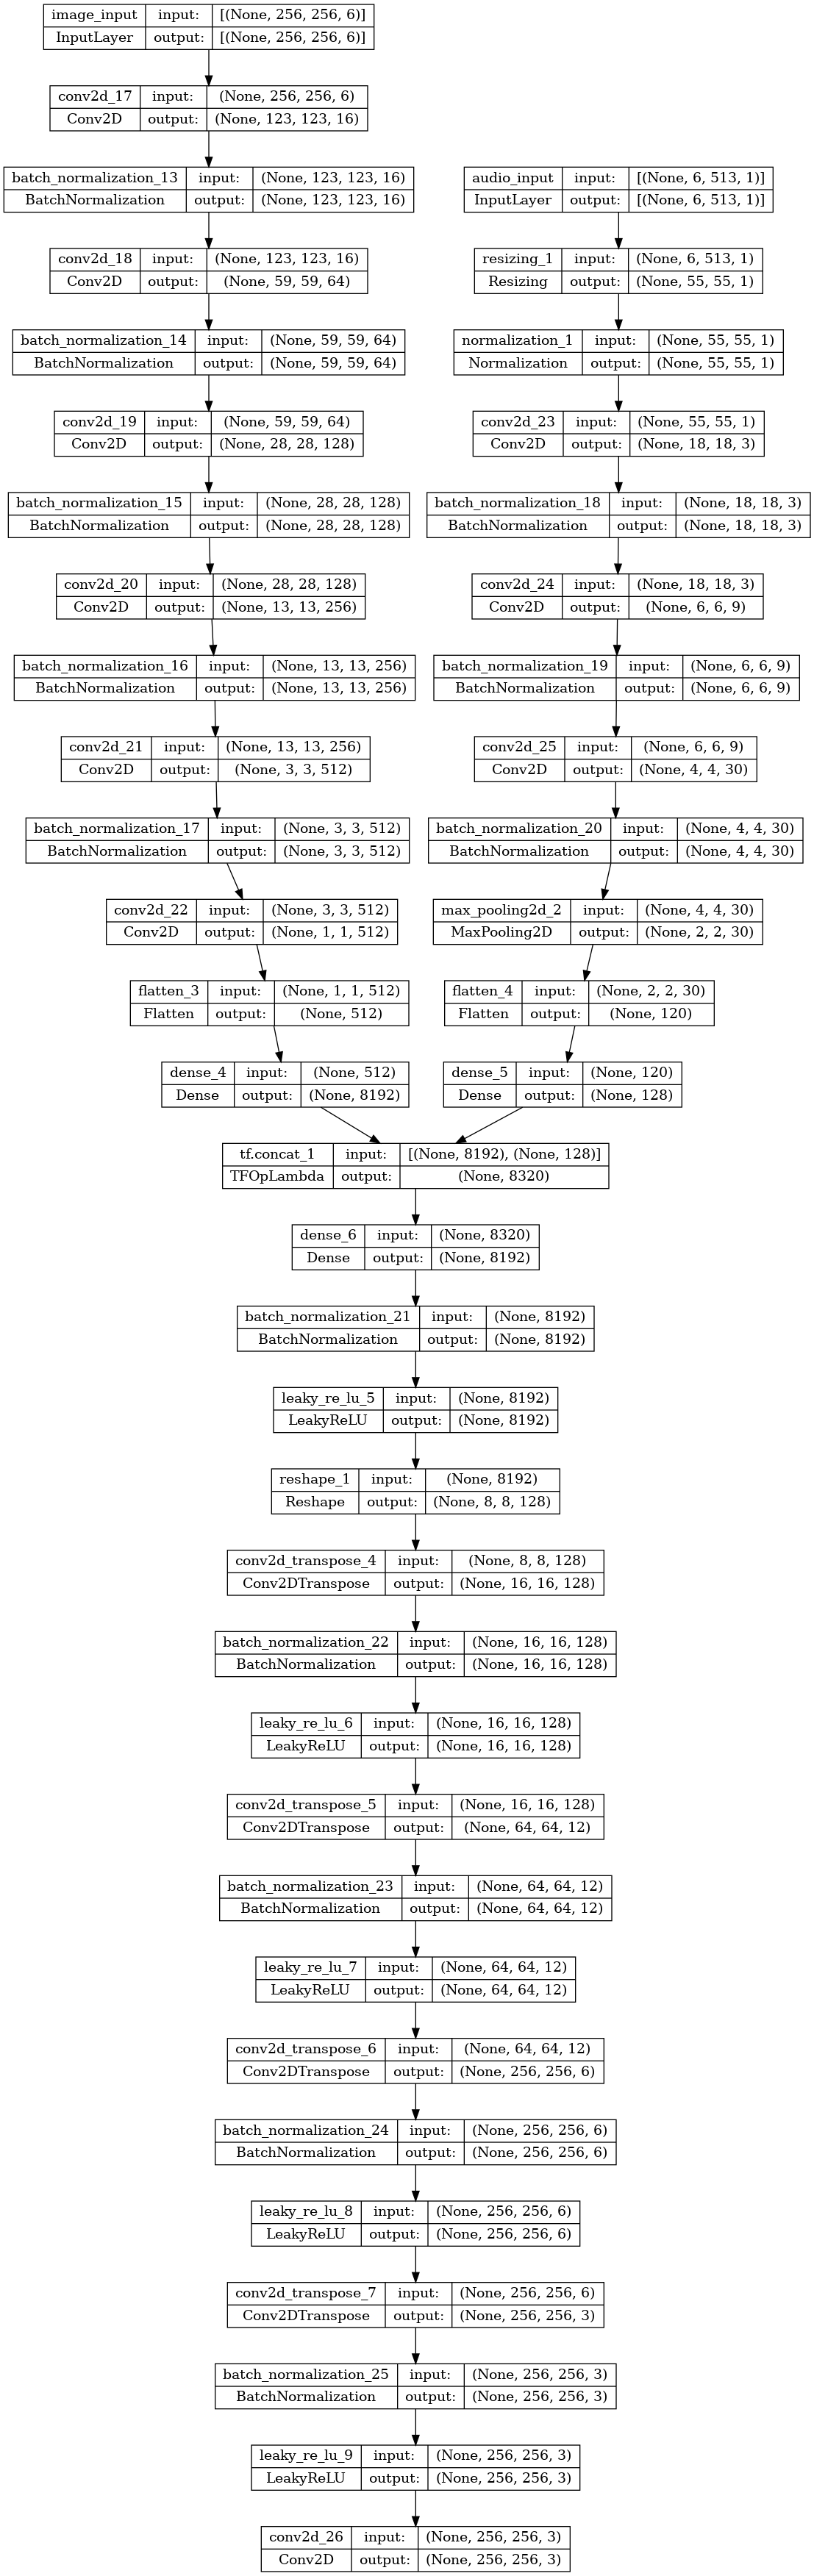

In [6]:
gen_plot = generator()
keras.utils.plot_model(gen_plot, "generator_plot.png", show_shapes=True)

# Define Loss Functions and Optimizers

In [7]:
# quality_discriminator_loss = keras.losses.BinaryCrossentropy(from_logits=True)
# generator_loss = keras.losses.MeanAbsoluteError() # Also known as L1 reconstruction loss

# generator_optimizer = tf.keras.optimizers.Adam(1e-3)
# quality_discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

# Misc

# Process generator input data
Essentially a reference face (pose prior) concatenated channel-wise with the masked original face

In [8]:
def process_gen_imgs(images): 
    """
    Assumes image is normalized beforehands and is a numpy array with shape (256, 256, 3)
    TODO: Random pose prior
    """
    output = []
    for img in images:
        img_masked = img.copy()
        # create a mask
        img_masked[256//2:,...] = 0

        # concatenate masked ground truth to pose prior
        img_concat = np.concatenate([POSE_PRIOR, img_masked], axis=2)
        # expected shape (256, 256, 6)
        output.append(img_concat)

    return output

In [9]:
# gen_loss_prog = keras.utils.Progbar(None, unit_name='generator_loss')
# disc_loss_prog = keras.utils.Progbar(None, unit_name='quality_discriminator_loss')
# disc_real_loss_prog = keras.utils.Progbar(None, unit_name='quality_discriminator_real_loss')
# @tf.function()
def train_step(images, gen_imgs, audio_samples):
    disc_loss, real_loss, gen_loss = 0., 0., 0.
    #with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    real = np.zeros((len(images), 1))
    fake = np.ones((len(images), 1))

    generated_images, gd_loss = gen([gen_imgs, audio_samples])
    
    # train discriminator
    disc_loss = qual_disc.train_on_batch(generated_images, fake)
    real_loss = qual_disc.train_on_batch(images, real)

    # gen_loss = generator_loss(images, generated_images)
    # disc_loss = quality_discriminator_loss(real_output, fake_output)

    # gradients_of_generator =  gen_tape.gradient(gen_loss, gen.trainable_variables)
    # gradients_of_quality_discriminator = disc_tape.gradient(disc_loss, qual_disc.trainable_variables)

    # generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    # quality_discriminator_optimizer.apply_gradients(zip(gradients_of_quality_discriminator, qual_disc.trainable_variables))

    # train generator
    total, mae, adv= gen.train_on_batch([gen_imgs, audio_samples], [images, real]) 
    print("Disc Loss: {} Real Loss: {} Total Gen Loss: {} MAE: {} Adv Loss: {}".format(disc_loss, real_loss, total, mae, adv))

    # gen_loss_prog.update(gen_loss)
    # disc_loss_prog.update(disc_loss)
    # disc_real_loss_prog.update(real_loss)

# Train

In [10]:
def train_in_batch(batch, epoch):
    start = time.time()
    train_step(batch[0], batch[1], batch[2])

    # Produces images for the GIF
    generate_and_save_images(gen, epoch + 1, test_img_arrs, test_img_concats, test_audio_arrs) # Maybe my face?
    # if (epoch+1) % 15 == 0:
    #     checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time for epoch {} is {} sec. Image Saved'.format(epoch+1, time.time()-start))
    

In [11]:
for epoch in range(EPOCHS):
    print("Epoch {} starting".format(epoch+1))
    start = time.time()
    batch = khoas_get_batch(BATCH_SIZE, epoch+1)
    display.clear_output(wait=True)
    print(f"Batch Acquisition time {time.time() - start} for epoch {epoch + 1}. Training...")
    train_in_batch(batch, epoch)

display.clear_output(wait=True)
generate_and_save_images(gen, epoch + 1, test_img_arrs, test_img_concats, test_audio_arrs) # Maybe my face?

Batch Acquisition time 27.059949159622192 for epoch 1. Training...


2023-02-11 05:44:34.661718: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-11 05:44:34.661750: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-11 05:44:34.703730: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-11 05:44:36.259142: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

ResourceExhaustedError: Graph execution error:

Detected at node 'model/combined_model/batch_normalization/FusedBatchNormV3' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/khoa/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/khoa/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/home/khoa/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/khoa/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/khoa/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/khoa/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/khoa/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/khoa/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/khoa/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/khoa/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/khoa/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/khoa/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/khoa/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/khoa/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/khoa/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3904276/2180023141.py", line 7, in <module>
      train_in_batch(batch, epoch)
    File "/tmp/ipykernel_3904276/664193470.py", line 3, in train_in_batch
      train_step(batch[0], batch[1], batch[2])
    File "/tmp/ipykernel_3904276/761399991.py", line 27, in train_step
      total, mae, adv= gen.train_on_batch([gen_imgs, audio_samples], [images, real])
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2478, in train_on_batch
      logs = self.train_function(iterator)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 866, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 659, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 633, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/combined_model/batch_normalization/FusedBatchNormV3'
OOM when allocating tensor with shape[98,32,246,246] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/combined_model/batch_normalization/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11229]

# Demo

In [ ]:
import imageio

anim_file = 'deepfake.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generated_images/image_at_epoch*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

    

# Test